In [2]:
import os
import pandas as pd
from funman import MODE_ODEINT, FunmanWorkRequest, GeneratedPetriNetModel
from funman_demo.helpers import run, get_model, setup_common, get_request, report


RESOURCES = "../resources"
SAVED_RESULTS_DIR = "./out"

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet","monthly-demo", "2024-09")
REQUEST_PATH = os.path.join(EXAMPLE_DIR, "sir_request1.json")

models = {
    "sir": os.path.join(EXAMPLE_DIR, "sir.json"),
}
requests = {
    "sir": REQUEST_PATH,
    "sir_stratified": os.path.join(EXAMPLE_DIR, "sir_stratified_request.json"),
    "sir_bounded_stratified": os.path.join(EXAMPLE_DIR, "sir_stratified_request.json"),
    "sir_bounded": os.path.join(EXAMPLE_DIR, "sir_bounded_request.json"),
    "sir_bounded_manual": os.path.join(EXAMPLE_DIR, "sir_bounded_request.json"),
    "sir_abstract_stratified_bounded": os.path.join(EXAMPLE_DIR, "sir_bounded_request.json")
}
request_params = {}
request_results = {}

In [3]:
# Constants for the scenario

MAX_TIME=50
STEP_SIZE=10
MODE=MODE_ODEINT
model_str = "sir"
beta_modifier = 0.00001
timepoints = list(range(0, MAX_TIME+STEP_SIZE, STEP_SIZE))

1 points
         beta  gamma
sir  0.000315    0.1


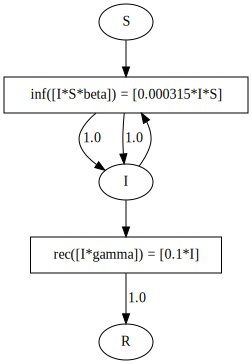

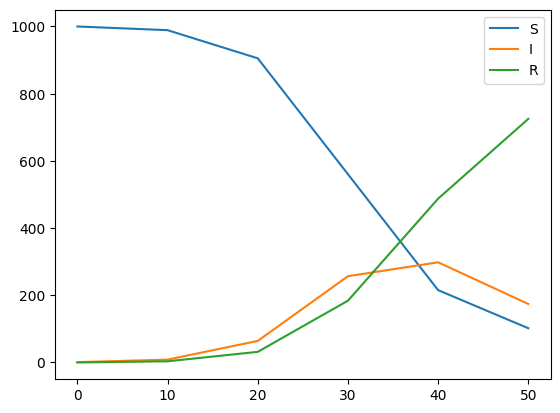

In [4]:
# 1) Process Base Model

(base_model, _) = get_model(models[model_str])
funman_request = get_request(requests[model_str])
setup_common(funman_request, timepoints, debug=True, mode=MODE, synthesize=False,dreal_precision=1)
base_results = run(funman_request, model_str, models)
report(base_results, model_str, base_model._state_var_names() + base_model._observable_names(), request_results, request_params)
base_model.to_dot()

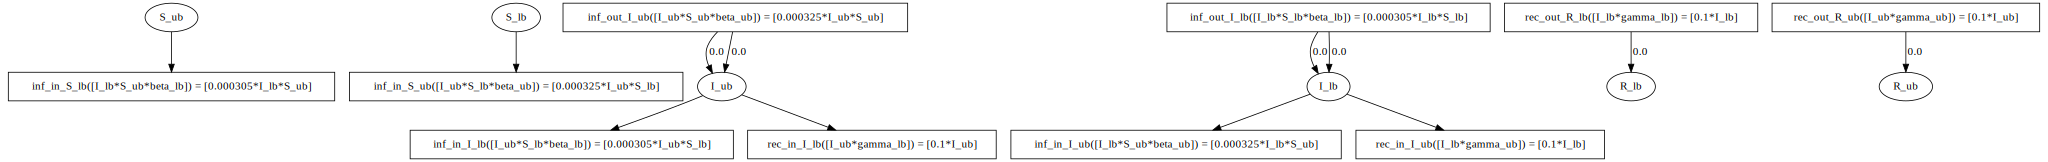

In [5]:
# 1.1) Bound the Base Model

bounded_model: GeneratedPetriNetModel = base_model.formulate_bounds()

# Modify the beta_1 and beta_2 parameters
parameters = bounded_model.petrinet.semantics.ode.parameters
beta_1 = next(p for p in parameters if p.id == "beta_lb")
beta_2 = next(p for p in parameters if p.id == "beta_ub")
beta_1.value -= beta_modifier
beta_2.value += beta_modifier

bounded_model_str = f"{model_str}_bounded"
bounded_model_path = os.path.join(EXAMPLE_DIR, bounded_model_str+".json")
models[bounded_model_str] = bounded_model_path
with open(bounded_model_path, "w") as f:
    f.write(bounded_model.petrinet.model_dump_json())


# 1.2) Analyze Bounded Base Model

bounded_request = FunmanWorkRequest() 
setup_common(bounded_request, timepoints, mode=MODE)
bounded_results = run(bounded_request, bounded_model_str, models)
# report(bounded_results, bounded_model_str, bounded_model._state_var_names() + bounded_model._observable_names(), request_results, request_params)
bounded_model.to_dot()

1 points
                    beta  gamma  beta_1_2_0  beta_1_2_1
sir             0.000315    0.1         NaN         NaN
sir_stratified       NaN    0.1    0.000305    0.000325


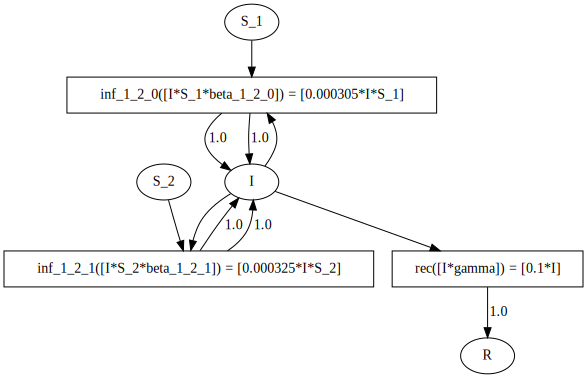

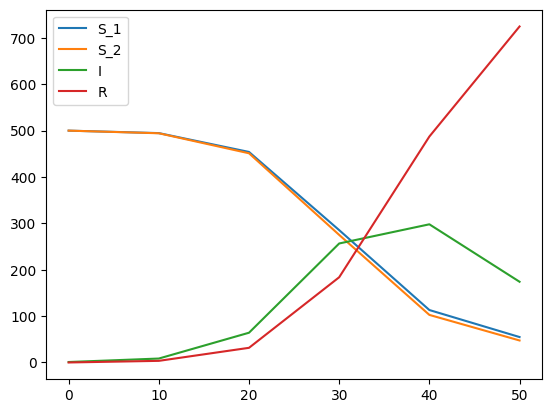

In [6]:
# 2.1) Stratify and Analyze the Base model with vaccination status

NUM_STRATA=2
stratified_model = base_model.stratify("S", [str(i+1) for i in range(0,NUM_STRATA)], strata_parameters=["beta"], self_strata_transition=False)

# 2.2) Analyze Stratified Base Model    
stratified_request = FunmanWorkRequest()

# Modify the beta_1 and beta_2 parameters
parameters = stratified_model.petrinet.semantics.ode.parameters
beta_1 = next(p for p in parameters if p.id == "beta_1_2_0")
beta_2 = next(p for p in parameters if p.id == "beta_1_2_1")
beta_1.value -= beta_modifier
beta_2.value += beta_modifier

stratified_model_str = f"{model_str}_stratified"
stratified_model_path = os.path.join(EXAMPLE_DIR, stratified_model_str+".json")
models[stratified_model_str] = stratified_model_path
with open(stratified_model_path, "w") as f:
    f.write(stratified_model.petrinet.model_dump_json())

setup_common(stratified_request, timepoints, mode=MODE)
stratified_results = run(stratified_request, stratified_model_str, models)
report(stratified_results, stratified_model_str, stratified_model._state_var_names() + stratified_model._observable_names(), request_results, request_params)
stratified_model.to_dot()

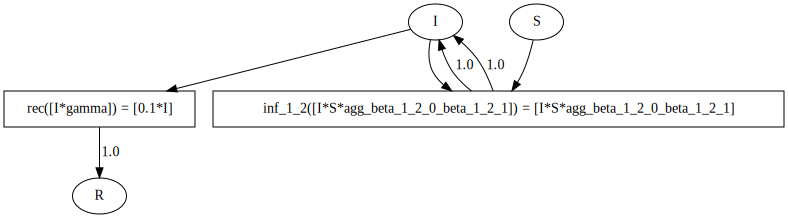

In [7]:
#  4)  Abstract the Stratified Base Model

abstract_stratified_model: GeneratedPetriNetModel = stratified_model.abstract({"S_1": "S", "S_2": "S"}) 

abstract_stratified_model_str = f"{model_str}_abstract_stratified"
abstract_stratified_model_path = os.path.join(EXAMPLE_DIR, abstract_stratified_model_str+".json")
models[abstract_stratified_model_str] = abstract_stratified_model_path
with open(abstract_stratified_model_path, "w") as f:
    f.write(abstract_stratified_model.petrinet.model_dump_json())

abstract_stratified_model.to_dot()

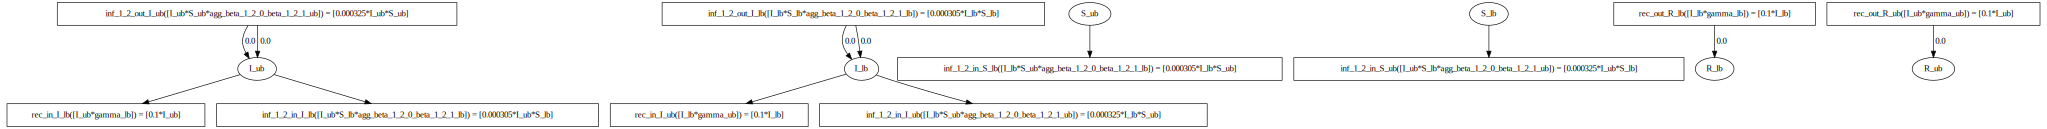

In [8]:
# 4) Bound and Analyze Abstract Stratified Bounded Base Model

# Bound the abstract stratified model
abstract_stratified_bounded_model: GeneratedPetriNetModel = abstract_stratified_model.formulate_bounds()
abstract_stratified_bounded_model_str = f"{model_str}_abstract_stratified_bounded"
abstract_stratified_bounded_model_path = os.path.join(EXAMPLE_DIR, abstract_stratified_bounded_model_str+".json")
models[abstract_stratified_bounded_model_str] = abstract_stratified_bounded_model_path
with open(abstract_stratified_bounded_model_path, "w") as f:
    f.write(abstract_stratified_bounded_model.petrinet.model_dump_json())

abstract_stratified_bounded_request = FunmanWorkRequest() #get_request(requests[abstract_stratified_bounded_model_str])
setup_common(abstract_stratified_bounded_request, timepoints, mode=MODE)
abs_results = run(abstract_stratified_bounded_request, abstract_stratified_bounded_model_str, models)
# report(abs_results, abstract_stratified_bounded_model_str, abstract_stratified_bounded_model._state_var_names() + abstract_stratified_bounded_model._observable_names(), request_results, request_params)
abstract_stratified_bounded_model.to_dot()

In [9]:
# Check if bounds are correct bounds

bs = [s for s in base_results.model._symbols() if s != "timer_t"]
base_df = base_results.dataframe(base_results.points())[bs]

ss = [s for s in stratified_results.model._symbols() if s != "timer_t"]
stratified_df = stratified_results.dataframe(stratified_results.points())[ss]
stratified_df["S"] = stratified_df.S_1 + stratified_df.S_2


bass = [s for s in abs_results.model._symbols() if s != "timer_t"]
bounded_abstract_df = abs_results.dataframe(abs_results.points())[bass]

destratified_df = pd.DataFrame(stratified_df)

def check_bounds(bounds_df, values_df, variable, values_model_name):
    failures = []
    lb = f"{variable}_lb"
    ub = f"{variable}_ub"
    if not all(values_df[variable] >= bounds_df[lb]):
        failures.append(f"The bounded abstract model does not lower bound the {values_model_name} model {variable}:\n{pd.DataFrame({lb:bounds_df[lb], variable: values_df[variable], f'{variable}-{lb}':values_df[variable]-bounds_df[lb]})}")
    if not all(values_df[variable] <= bounds_df[ub]):
        failures.append(f"The bounded abstract model does not upper bound the {values_model_name} model {variable}:\n{pd.DataFrame({ub:bounds_df[ub], variable: values_df[variable], f'{ub}-{variable}':bounds_df[ub]-values_df[variable]})}")
    return failures

all_failures = []
for (values_df, model) in [(base_df, "base"), (destratified_df, "stratified")]:
    for var in ["S", "I", "R"]:
        all_failures += check_bounds(bounded_abstract_df, values_df, var, model)

reasons = '\n'.join(map(str, all_failures))
assert len(all_failures) == 0, f"The bounds failed in the following cases:\n{reasons}"


In [10]:
# base_df[["S", "I", "R"]].plot()
# stratified_df[["S", "I", "R"]].plot()
# bounded_abstract_df[["S_lb", "S_ub", "I_lb", "I_ub", "R_lb", "R_ub"]].plot()
print(base_df[["S", "I", "R"]])
print(stratified_df[["S", "I", "R"]])
print(bounded_abstract_df[["S_lb", "S_ub", "I_lb", "I_ub", "R_lb", "R_ub"]])

              S           I           R
0   1000.000000    1.000000    0.000000
1    998.900405    1.748584    0.351011
2    997.800810    2.497168    0.702022
3    996.701215    3.245751    1.053034
4    995.601620    3.994335    1.404045
5    994.502025    4.742919    1.755056
6    993.402430    5.491503    2.106067
7    992.302835    6.240087    2.457078
8    991.203240    6.988670    2.808089
9    990.103645    7.737254    3.159101
10   989.004050    8.485838    3.510112
11   980.624414   14.054870    6.320716
12   972.244778   19.623903    9.131319
13   963.865142   25.192935   11.941923
14   955.485506   30.761967   14.752527
15   947.105870   36.331000   17.563130
16   938.726234   41.900032   20.373734
17   930.346598   47.469064   23.184338
18   921.966962   53.038096   25.994942
19   913.587326   58.607129   28.805545
20   905.207690   64.176161   31.616149
21   870.721931   83.436439   46.841630
22   836.236171  102.696717   62.067111
23   801.750412  121.956996   77.292592
